dataset = "dialogsum" | "samsum"

dataset_type = "train" | "test" | "validation"

In [3]:
from datasets import load_dataset
import json, pandas as pd, numpy as np 
from sentence_transformers import SentenceTransformer, util
from tqdm import tqdm

In [4]:
dataset = "dialogsum"
dataset_type = "validation"

FILTERED_COMET_FILE_PATH = f"./comet_{dataset_type}.json"
DIALOGSUM_FILE_PATH =  f"./dialogsum.{dataset_type}.jsonl"

In [13]:
summary_dict = None
dilaogsum = None
if dataset == "samsum":
    samsum = load_dataset('samsum')
    summary_dict = dict([(obj["id"], obj["summary"]) for obj in samsum[dataset_type]])
elif dataset == "dialogsum":
       dilaogsum = pd.read_json(path_or_buf=DIALOGSUM_FILE_PATH, lines=True)
       summary_dict = dict([(obj["fname"], obj["summary"]) for _, obj in dilaogsum[["fname","summary"]].iterrows()])
else:
    raise NotImplementedError()

In [15]:
comet = None
with open(FILTERED_COMET_FILE_PATH) as f:
    comet = json.loads(f.read())

In [16]:
cs_unraveled = []
for sample_id, sammple_cs in comet.items():
    for sentence_num, sentence_obj in enumerate(sammple_cs):
        for cs_key_or_sentence, cs_arr_or_sentence in sentence_obj.items():
            if type(cs_arr_or_sentence) == type([]):
                for cs in cs_arr_or_sentence:
                    cs_unraveled.append({"sample_id":sample_id,"sentence_id":sentence_num, \
                    "sentence":sentence_obj["sentence"], "cs_type":cs_key_or_sentence, "cs":cs, "summary":summary_dict[sample_id]})

In [17]:
len([obj["sentence"] for obj in cs_unraveled]) == sum([len(sentences) for _, sentences in comet.items()])*25

True

### Model details:
https://github.com/UKPLab/sentence-transformers

In [19]:
sbert = SentenceTransformer('all-MiniLM-L6-v2', device='cuda')

In [20]:
cs_unraveled[0]

{'sample_id': 'dev_0',
 'sentence_id': 0,
 'sentence': '#Person1#:',
 'cs_type': 'HinderedBy',
 'cs': ' Person1 has to go to work.',
 'summary': '#Person2# has trouble breathing. The doctor asks #Person2# about it and will send #Person2# to a pulmonary specialist.'}

In [108]:
cs_final= []
for cs_obj in tqdm(cs_unraveled):
    cs_emb =  sbert.encode(cs_obj["cs"])
    summary_emb = sbert.encode(cs_obj["summary"])
    sentence_emb = sbert.encode(cs_obj["sentence"])
    cs_final.append({**cs_obj,
                     "sentence_encoded":sentence_emb,"cs_encoded":cs_emb, "sumary_encoded":summary_emb,
                     "cos_similary_cs_summmary":float(util.cos_sim(cs_emb, summary_emb)),
                     "cos_similary_cs_sentence":float(util.cos_sim(cs_emb, sentence_emb))})

100%|██████████| 4000/4000 [02:45<00:00, 24.21it/s]


In [109]:
cs_dp = pd.DataFrame(cs_final)

In [110]:
cs_dp.iloc[:2,:]

,sample_id,sentence_id,sentence,cs_type,cs,summary,sentence_encoded,cs_encoded,sumary_encoded,cos_similary_cs_summmary,cos_similary_cs_sentence
0,dev_0,0,#Person1#:,HinderedBy,Person1 has to go to work.,#Person2# has trouble breathing. The doctor as...,"[-0.09448934, -0.016497305, 0.05388772, -0.027...","[-0.0748776, -0.026539037, -0.016843293, 0.005...","[-0.0029337523, 0.031956818, 0.03461453, -0.00...",0.405971,0.474118
1,dev_0,0,#Person1#:,HinderedBy,#Person1# has no money.,#Person2# has trouble breathing. The doctor as...,"[-0.09448934, -0.016497305, 0.05388772, -0.027...","[-0.026719712, 0.0034984215, 0.034878585, -0.0...","[-0.0029337523, 0.031956818, 0.03461453, -0.00...",0.353232,0.727654


In [111]:
peaks = [max(list(cs_dp["cos_similary_cs_summmary"])[25*(i-1):25*i]) for i in range(1,int(len(cs_dp)/25))]

In [112]:
best_cs_per_sentence_ours = cs_dp.loc[cs_dp.groupby(['sample_id','sentence_id'])['cos_similary_cs_summmary'].idxmax()]

In [113]:
best_cs_per_sentence_theirs = cs_dp.loc[cs_dp.groupby(['sample_id','sentence_id'])['cos_similary_cs_sentence'].idxmax()]

In [114]:
peaks_ours = best_cs_per_sentence_ours["cos_similary_cs_summmary"]
peaks_theirs = best_cs_per_sentence_theirs["cos_similary_cs_sentence"]

In [115]:
np.average(peaks_ours), np.std(peaks_ours)

(0.5103861989453435, 0.09320694605810319)

In [116]:
np.average(peaks_theirs), np.std(peaks_theirs)

(0.5913919324055315, 0.14299559761214137)

In [117]:
len([n1+n2/2 for n1, n2 in zip(peaks_theirs, peaks_ours)])

160

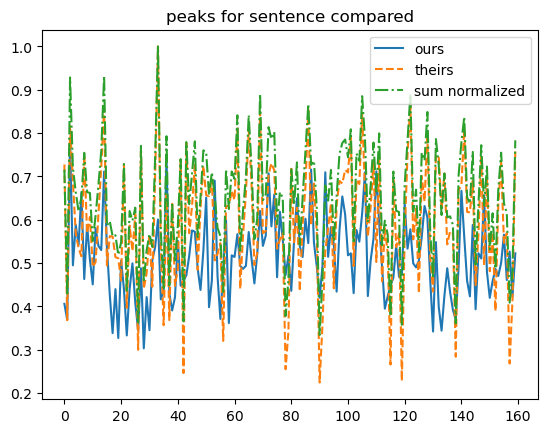

In [118]:
import matplotlib.pyplot as plt
plt.plot(range(0,len(peaks_ours)),peaks_ours,  label ="ours")
plt.plot(range(0,len(peaks_theirs)), peaks_theirs,  label ="theirs", linestyle="--")
plt.plot(range(0,len(peaks_theirs)), np.array([n1+n2/2 for n1, n2 in zip(peaks_theirs, peaks_ours)])/max([n1+n2/2 for n1, n2 in zip(peaks_theirs, peaks_ours)]),  label ="sum normalized", linestyle="-.")
plt.title("peaks for sentence compared")
plt.legend() 
plt.show()